In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
embedding_layer = layers.Embedding(1000, 5)

In [4]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.03943647, -0.02123259,  0.02883771,  0.04740273,  0.01876817],
       [ 0.01335864,  0.04990875,  0.03005354, -0.02700813, -0.00384589],
       [ 0.00146097, -0.0207228 , -0.03795981,  0.00510196, -0.03581574]],
      dtype=float32)

In [5]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [6]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDC9A3L/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDC9A3L/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDC9A3L/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [7]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [8]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [9]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[2079,   36, 7998, ...,    0,    0,    0],
       [  62, 1175,   18, ...,    0,    0,    0],
       [  12,  456,   45, ...,    0,    0,    0],
       ...,
       [7963,  275, 5970, ...,    0,    0,    0],
       [ 249, 5997,  713, ...,    0,    0,    0],
       [  19, 7301,    6, ...,    0,    0,    0]])

Create a simple model

In [10]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.4878 - accuracy: 0.7168 - val_loss: 0.3881 - val_accuracy: 0.8700
Epoch 2/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2731 - accuracy: 0.8847 - val_loss: 0.3562 - val_accuracy: 0.8700
Epoch 3/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2200 - accuracy: 0.9125 - val_loss: 0.3894 - val_accuracy: 0.8600
Epoch 4/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1915 - accuracy: 0.9280 - val_loss: 0.4650 - val_accuracy: 0.8550
Epoch 5/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1704 - accuracy: 0.9366 - val_loss: 0.4651 - val_accuracy: 0.8200
Epoch 6/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1521 - accuracy: 0.9433 - val_loss: 0.3909 - val_accuracy: 0.8650
Epoch 7/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1405 - accuracy: 0.9486 - val_loss: 0.3980 - val_ac

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20, callbacks=[es])

Epoch 1/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1020 - accuracy: 0.9650 - val_loss: 0.5542 - val_accuracy: 0.8550
Epoch 2/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.0929 - accuracy: 0.9678 - val_loss: 0.5986 - val_accuracy: 0.8650
Epoch 00002: early stopping


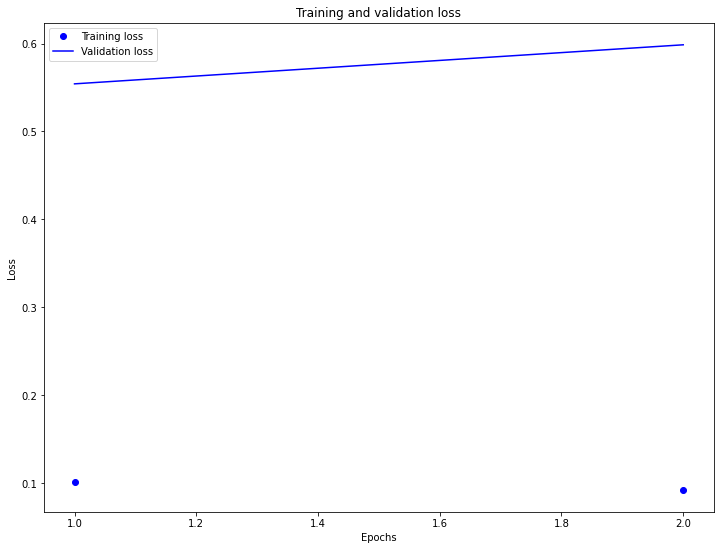

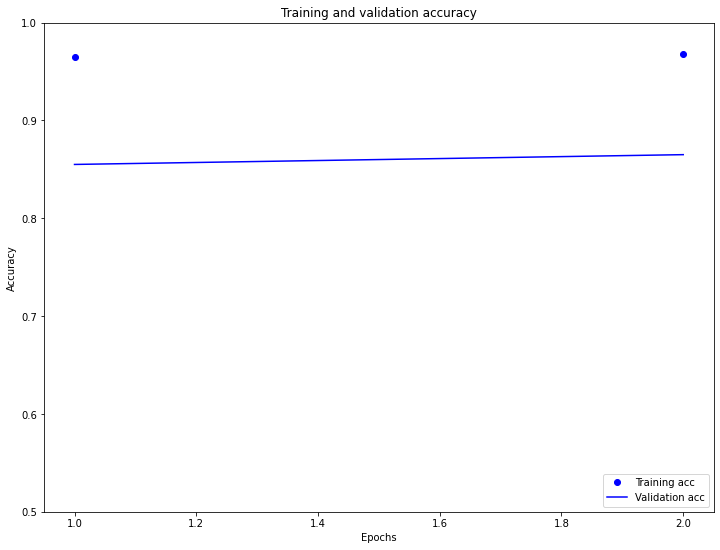

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

Retrieve the learned embeddings

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


Visualize using Embedding Projector

In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the <a href=http://projector.tensorflow.org/>Embedding Projector</a> (this can also run in a local TensorBoard instance).

Click on "Load data".

Upload the two files we created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".